# 1) Sample the parameter space

From the set of parameters estimated using multiple patch recordings (1 somatic, 2 apical dendrites), we simulate random perturbations using Latin Hypercube Sampling (LHS).

The random parameters are saved in the `config/params/random.csv` and will be used to assess the fitting performance of different feature sets.

In [1]:
%load_ext autoreload
%autoreload

from pyDOE import lhs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import json
from pathlib import Path
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
save_params = False

In [3]:
release_params = {
    'gNaTs2_tbar_NaTs2_t.apical': 0.026145,
    'gSKv3_1bar_SKv3_1.apical': 0.004226,
    'gImbar_Im.apical': 0.000143,
    'gNaTa_tbar_NaTa_t.axonal': 3.137968,
    'gK_Tstbar_K_Tst.axonal': 0.089259,
    'gamma_CaDynamics_E2.axonal': 0.002910,
    'gNap_Et2bar_Nap_Et2.axonal': 0.006827,
    'gSK_E2bar_SK_E2.axonal': 0.007104,
    'gCa_HVAbar_Ca_HVA.axonal': 0.000990,
    'gK_Pstbar_K_Pst.axonal': 0.973538,
    'gSKv3_1bar_SKv3_1.axonal': 1.021945,
    'decay_CaDynamics_E2.axonal': 287.198731,
    'gCa_LVAstbar_Ca_LVAst.axonal': 0.008752,
    'gamma_CaDynamics_E2.somatic': 0.000609,
    'gSKv3_1bar_SKv3_1.somatic': 0.303472,
    'gSK_E2bar_SK_E2.somatic': 0.008407,
    'gCa_HVAbar_Ca_HVA.somatic': 0.000994,
    'gNaTs2_tbar_NaTs2_t.somatic': 0.983955,
    'decay_CaDynamics_E2.somatic': 210.485284,
    'gCa_LVAstbar_Ca_LVAst.somatic': 0.000333
}

# load param configs for boundary values
param_configs = json.load(open('config/parameters.json'))

In [4]:
n_params = len(release_params)
n_samples = 100  # number of random samples 
lim_dev = 0.2  # limits for each param are: [release_val-lim_dev*release_val, release_val+lim_dev*release_val] 

### Latin hypercube sampling (normal 0-1)

In [5]:
random_samples = lhs(n_params, samples=n_samples)

<IPython.core.display.Javascript object>


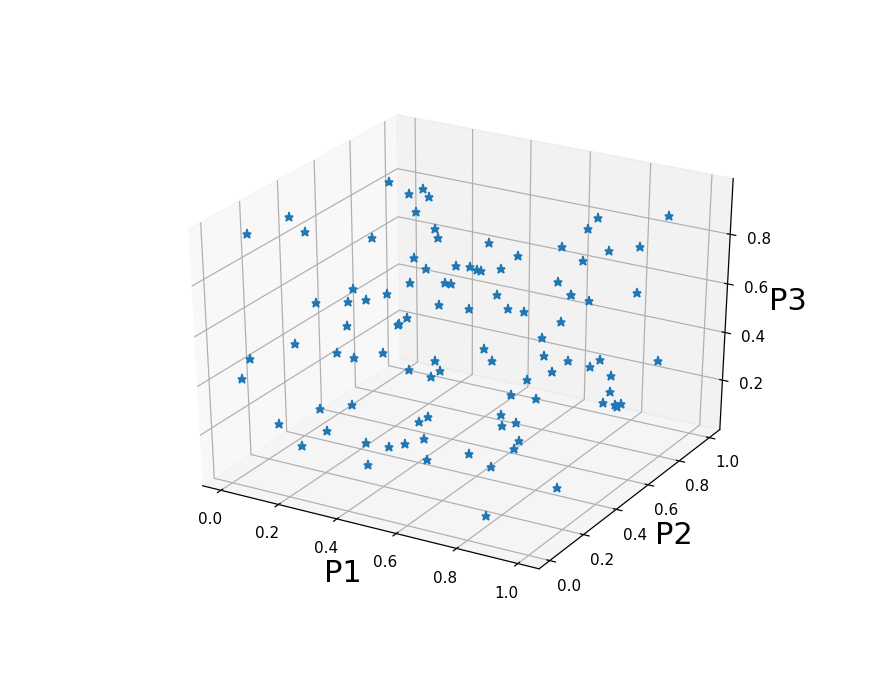

Text(0.5, 0, 'P3')

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(random_samples[:, 5], random_samples[:, 19], random_samples[:, 3], '*')
ax.set_xlabel('P1', fontsize=20)
ax.set_ylabel('P2', fontsize=20)
ax.set_zlabel('P3', fontsize=20)

### Compute parameters limits

In [133]:
param_lims = {}

for par, val in release_params.items():
    dev = lim_dev * val
    lims = [val - dev, val + dev]
    
    # check values based on param configs
    for param in param_configs:
        name, loc = par.split('.')
        if param['param_name'] == name and param['sectionlist'] == loc:
            if 'bounds' in param:
                if lims[0] < param['bounds'][0]:
                    lims[0] = param['bounds'][0]
                    print(f'Param {par} changed lower bound')                    
                if lims[1] > param['bounds'][1]:
                    lims[1] = param['bounds'][1]
                    print(f'Param {par} changed upper bound')
    param_lims[par] = lims

Param gK_Tstbar_K_Tst.axonal changed upper bound
Param gCa_HVAbar_Ca_HVA.axonal changed upper bound
Param gK_Pstbar_K_Pst.axonal changed upper bound
Param gCa_LVAstbar_Ca_LVAst.axonal changed upper bound
Param gamma_CaDynamics_E2.somatic changed lower bound
Param gCa_HVAbar_Ca_HVA.somatic changed upper bound
Param gNaTs2_tbar_NaTs2_t.somatic changed upper bound


In [134]:
scaled_samples = np.zeros_like(random_samples)

for i, sample in enumerate(random_samples):
    for j, (par, parlim) in enumerate(param_lims.items()):
        scaled_samples[i, j] = (parlim[1] - parlim[0]) * sample[j] + parlim[0] 

In [135]:
for sample in scaled_samples:
    for j, (par, parlim) in enumerate(param_lims.items()):
        assert parlim[0] < sample[j] < parlim[1] 

In [136]:
# creata dataframe
df_release = pd.DataFrame(data=release_params, index=['release'])
df_random = pd.DataFrame(data=scaled_samples, columns=param_lims.keys(), 
                         index=[f'random_{i}' for i in range(n_samples)])

<IPython.core.display.Javascript object>


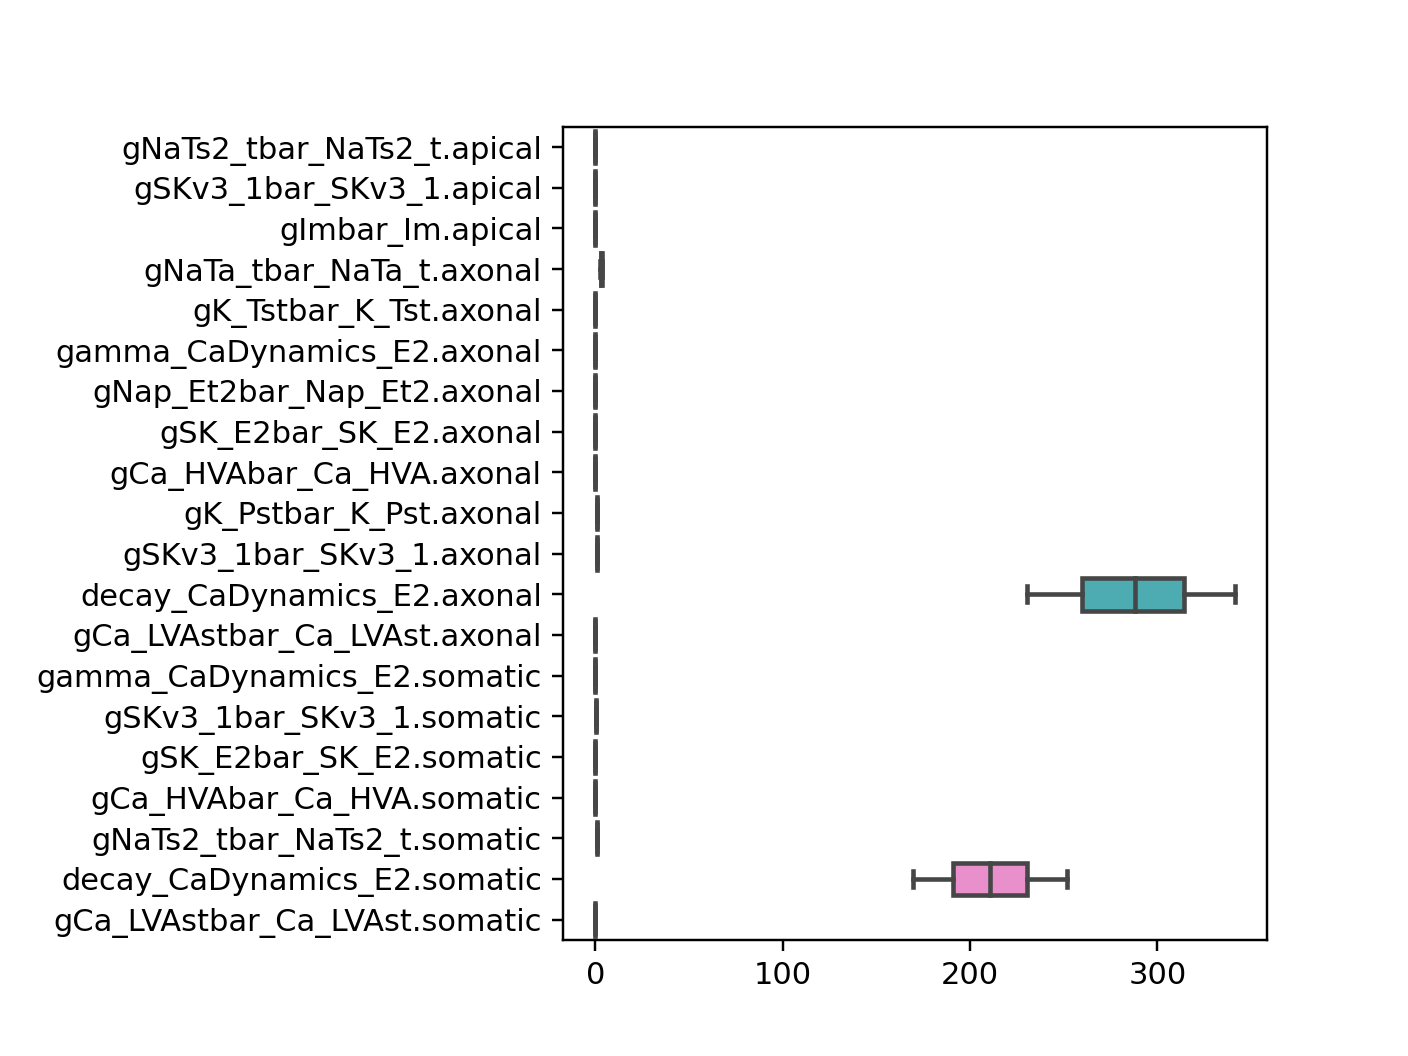

In [138]:
plt.figure()
ax = sns.boxplot(data=df_random, orient='horizontal')
fig = ax.get_figure()
fig.subplots_adjust(left=0.4)

### Save random and releas parameters to csv

In [139]:
if save_params:
    params_folder = Path('config/params')

    if not params_folder.is_dir():
        os.makedirs(params_folder)

    release_params_file = params_folder / 'release.csv'
    random_params_file = params_folder / 'random.csv'

    df_release.to_csv(release_params_file, index_label='index')
    df_random.to_csv(random_params_file, index_label='index')    